Total cost: 1871
Route 1: [0, 20, 21, 47, 0]
Truck capacity: 40.0
Total distance travelled: 47.027756377319946
Starting time: 0h00
Ending time: 19h22
Total time: 19h22

Route 2: [0, 22, 49, 0]
Truck capacity: 30.0
Total distance travelled: 48.37489777289498
Starting time: 13h20
Ending time: 31h50
Total time: 18h30

Route 3: [0, 67, 65, 63, 62, 66, 69, 75, 0]
Truck capacity: 130.0
Total distance travelled: 71.0179439165756
Starting time: 0h00
Ending time: 19h04
Total time: 19h04

Route 4: [0, 23, 52, 0]
Truck capacity: 20.0
Total distance travelled: 54.43695185175311
Starting time: 11h59
Ending time: 29h02
Total time: 17h03

Route 5: [0, 24, 25, 27, 28, 26, 34, 50, 0]
Truck capacity: 120.0
Total distance travelled: 88.73019473647331
Starting time: 0h50
Ending time: 17h06
Total time: 16h16

Route 6: [0, 5, 3, 4, 1, 0]
Truck capacity: 40.0
Total distance travelled: 39.814287642690964
Starting time: 0h00
Ending time: 17h01
Total time: 17h01

Route 7: [0, 7, 8, 9, 6, 2, 0]
Truck capacity: 1

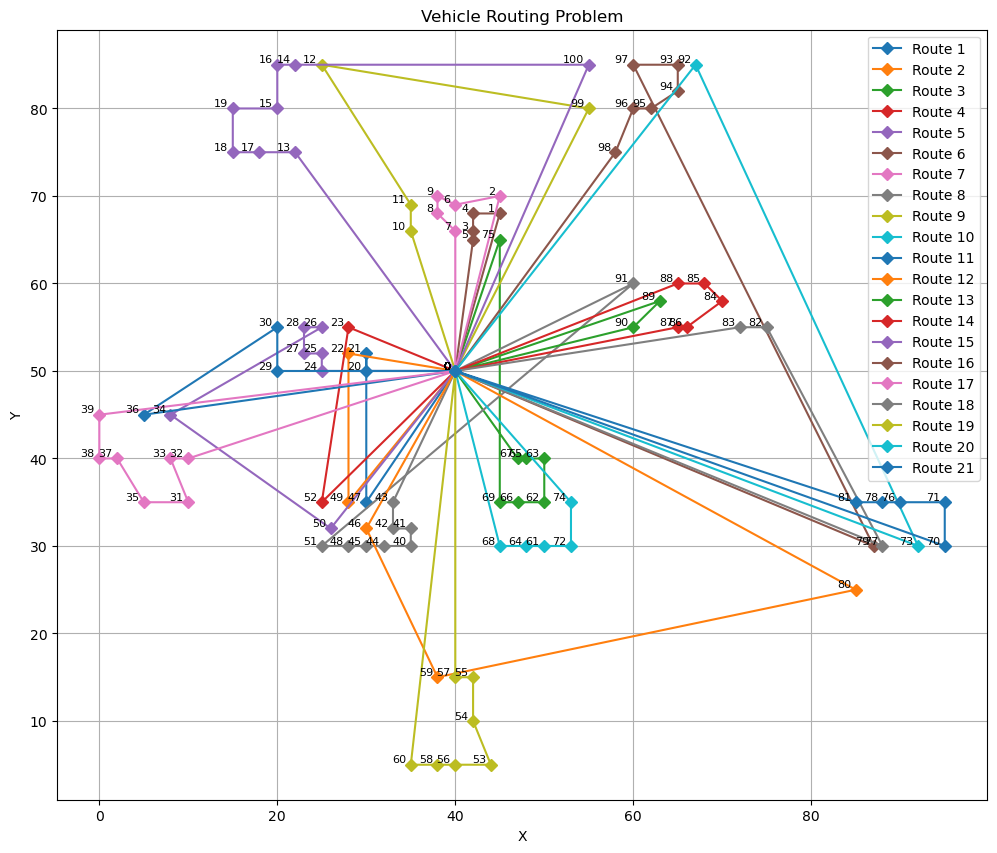

In [155]:
# used ressource :
# https://medium.com/@writingforara/solving-vehicle-routing-problems-with-python-heuristics-algorithm-2cc57fe7079c

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

def read_excel_file(file_path, sheet_name):
    """
    Read coordinates and demand values from a specific sheet in an Excel file.
    Assumes the data is in columns labeled 'X', 'Y', and 'Demand'.
    """
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    coordinates = df[['X', 'Y']].values
    demands = df['Demand'].values
    return coordinates, demands

def read_txt_file(file_path):
    """
    Reads a VRP text file and extracts vehicle and customer informations.
    """
    with open(file_path, 'r') as file:      # Read data
        lines = file.readlines()            # Split data into line
    vehicle_info = lines[4].split()         # Informations about vehicles are on line 5 for Solomon instance (index 4)
    vehicle_number = vehicle_info[0]        # Number of vehicle available
    vehicle_capacity = vehicle_info[1]      # Maximun capacity allowed in vehicle
    customer_data_start = lines.index("CUSTOMER\n") + 3  # Informations about customers start 3 lines after the index of the word "CUSTOMER"
    customer_lines = lines[customer_data_start:]
    
    coordinates = []
    demands = []
    ready_times = []
    due_times = []
    service_times = []
    
    for line in customer_lines:
        if line.strip():  # Skip empty lines
            values = list(map(float, line.split()))
            coordinates.append((values[1], values[2]))
            demands.append(values[3]) 
            ready_times.append(values[4])  
            due_times.append(values[5])  
            service_times.append(values[6]) 
    
    return vehicle_number, vehicle_capacity, coordinates, demands, ready_times, due_times, service_times
   
def adjacency_matrix(coordinates):
    """
    Calculate the adjacency matrix.
    """
    num_points = len(coordinates)
    adj_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            adj_matrix[i, j] = calculate_distance(coordinates, i, j)
    return adj_matrix

def calculate_distance(coordinates, i, j):
    """
    Calculate the Euclidean distance between two points.
    """
    x1, y1 = coordinates[i]
    x2, y2 = coordinates[j]
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def calculate_total_distance(route, adj_matrix):
    """
    Calculate the total distance of a given route using the distance matrix.
    """
    total_distance = 0
    num_points = len(route)
    for i in range(num_points - 1):
        current_node = route[i]
        next_node = route[i + 1]
        total_distance += adj_matrix[current_node, next_node]
    return total_distance

def nearest_neighbor_with_time_windows(adj_matrix, demands, capacity_max, earliest_time, latest_time, service_time):
    """
    Nearest Neighbor heuristic with time windows.
    """
    num_points = adj_matrix.shape[0]                    # Count rows in matrix to get the number of point
    visited = [False] * num_points                      # Boolean array to inform if a point was visited or not
    routes = []                                         # Array including multiple routes
    capacity_list = []                                  # Array stocking final capacity of each route
    time_list = []                                      # Array keeping total time needed for each route in mind
    start_list = []                                     # Array stocking starting time of one travel

    while sum(visited) < num_points:                    # While all point are not visited
        current_node = 0                                # Start at the depot
        current_capacity = 0                            # Initialize empty capacity
        current_time = earliest_time[current_node]      # Initialize current_time to the READY TIME of the depot (often 0)
        route = [current_node]                          # Array stocking the current route starting with the depot (current_node = 0)
        visited[current_node] = True                    # Current node is now visited

        while True:
            last_node = route[-1]                       # last_node is the last element in route
            nearest = None                              # nearest correspond to the next nearest neighbor (which is unknown here)
            min_distance = float('inf')                 # min_distance must be initialized with the max value possible to not bias the results

            for neighbor in [i for i, v in enumerate(visited) if not v]:
                travel_time = adj_matrix[last_node, neighbor]                   # We suppose time = distance (1 unit of distance take 1 unit of time)
                arrival_time = current_time + travel_time                

                if (demands[neighbor] + current_capacity <= capacity_max        # If the truck capacity is not higher than the capacity max
                        and arrival_time <= latest_time[neighbor]               # and if the arrival_time is not higher than the LATEST TIME of the neighbor
                        and adj_matrix[last_node, neighbor] < min_distance):    # and if the distance betweeen last node and a neighbor is lower than min ditance 
                    nearest = neighbor                                   
                    min_distance = adj_matrix[last_node, neighbor]              # We change the value of the nearest node and min_distance

            # If we dont find any other neighbor, we stop the route
            if nearest is None:                         
                break

            # Update route, time, and capacity
            travel_time = adj_matrix[last_node, nearest]
            current_time += travel_time
            current_time = max(current_time, earliest_time[nearest])  # Wait if arriving early
            current_time += service_time[nearest]  # Add service time
            route.append(nearest)
            visited[nearest] = True
            current_capacity += demands[nearest]

        # Return to depot
        travel_time = adj_matrix[route[-1], 0]      # Give travel time between last node and the depot
        current_time += travel_time
        route.append(0)                             

        routes.append(route)                        # Add the route to all routes
        capacity_list.append(current_capacity)      # Add current_capacity to the capacity_list to keep the information in mind
        time_list.append(current_time)              # Add current_time to the time_list to keep the information in mind
        
        start_list.append(max(0, earliest_time[route[1]] - adj_matrix[route[0], route[1]]))

    return routes, capacity_list, time_list, start_list         # Return all routes (with capacity and time)

def format_output(routes):
    """
    Format the final routes as required.
    """
    routes = [[int(node) for node in route] for route in routes]
    return routes

def convert_time(time):
    """
    Format time (XhXX).
    """
    hour, minutes = divmod(round(time), 60)  # divmod gives hours and minutes
    return f"{hour}h{minutes:02d}"

def plot_routes_with_coordinates(coordinates, solution):
    """
    Displays routes.
    """
    coordinates = np.array(coordinates)
    plt.figure(figsize=(12, 10))
    for index, route in enumerate(solution):
        route_coordinates = coordinates[route]
        plt.plot(route_coordinates[:, 0], route_coordinates[:, 1], 
                 marker='D', linestyle="solid", label=f"Route {index + 1}")
        for i, (x, y) in enumerate(route_coordinates):
            plt.text(x - 0.5, y, str(route[i]), fontsize=8, ha="right", va='bottom')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Vehicle Routing Problem")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def vrp_solver(location):
    """
    Solve the VRP with time windows using the provided location for coordinates and constraints.
    """
    nb_vehicle, capacity_max, coordinates, demand, earliest_time, latest_time, service_time = read_txt_file(location)
    adj_matrix = adjacency_matrix(coordinates)
    all_routes, capacity_list, route_times, start_list = nearest_neighbor_with_time_windows(adj_matrix, demand, int(capacity_max), earliest_time, latest_time, service_time)
    route_distances = [calculate_total_distance(route, adj_matrix) for route in all_routes]
    all_routes = format_output(all_routes)
    cost = sum(calculate_total_distance(route, adj_matrix) for route in all_routes)
    return all_routes, capacity_list, route_distances, route_times, coordinates, start_list, cost


folder = "..\\Dataset\\" 
dataset_name = "c101"
location = folder + dataset_name + ".txt"
solution, capacity_list, route_distances, route_times, coordinates, start_list, cost = vrp_solver(location)
n = 0
print("Total cost: " + str(ceil(cost)))
for route, distance, route_time, start in zip(solution, route_distances, route_times, start_list):
    end = convert_time(start + route_time)
    print(f"Route {n+1}: {route}\nTruck capacity: {capacity_list[n]}\n"
          f"Total distance travelled: {distance}\n"
          f"Starting time: {convert_time(start)}\n"
          f"Ending time: {end}\n"          
          f"Total time: {convert_time(route_time)}\n"
          )
    n += 1
    
plot_routes_with_coordinates(coordinates, solution)
   

### Two-Opt Algorithm and SA Algorithm (Seperated)


Route 1: [0, 53, 58, 0]
Truck capacity: 32.0
Total distance travelled: 18.626540606729783
Starting time: 1h31
Ending time: 5h10
Total time: 3h39

Route 2: [0, 27, 69, 1, 70, 0]
Truck capacity: 37.0
Total distance travelled: 45.90952670230763
Starting time: 0h32
Ending time: 4h05
Total time: 3h33

Route 3: [0, 28, 26, 80, 0]
Truck capacity: 39.0
Total distance travelled: 48.5202409887696
Starting time: 0h33
Ending time: 4h06
Total time: 3h33

Route 4: [0, 89, 0]
Truck capacity: 15.0
Total distance travelled: 18.0
Starting time: 2h47
Ending time: 6h02
Total time: 3h15

Route 5: [0, 6, 96, 93, 0]
Truck capacity: 36.0
Total distance travelled: 40.671437305934816
Starting time: 1h28
Ending time: 5h06
Total time: 3h38

Route 6: [0, 13, 100, 0]
Truck capacity: 40.0
Total distance travelled: 49.11441443729137
Starting time: 2h28
Ending time: 6h07
Total time: 3h39

Route 7: [0, 40, 74, 25, 0]
Truck capacity: 23.0
Total distance travelled: 78.38622414631112
Starting time: 1h14
Ending time: 4h57


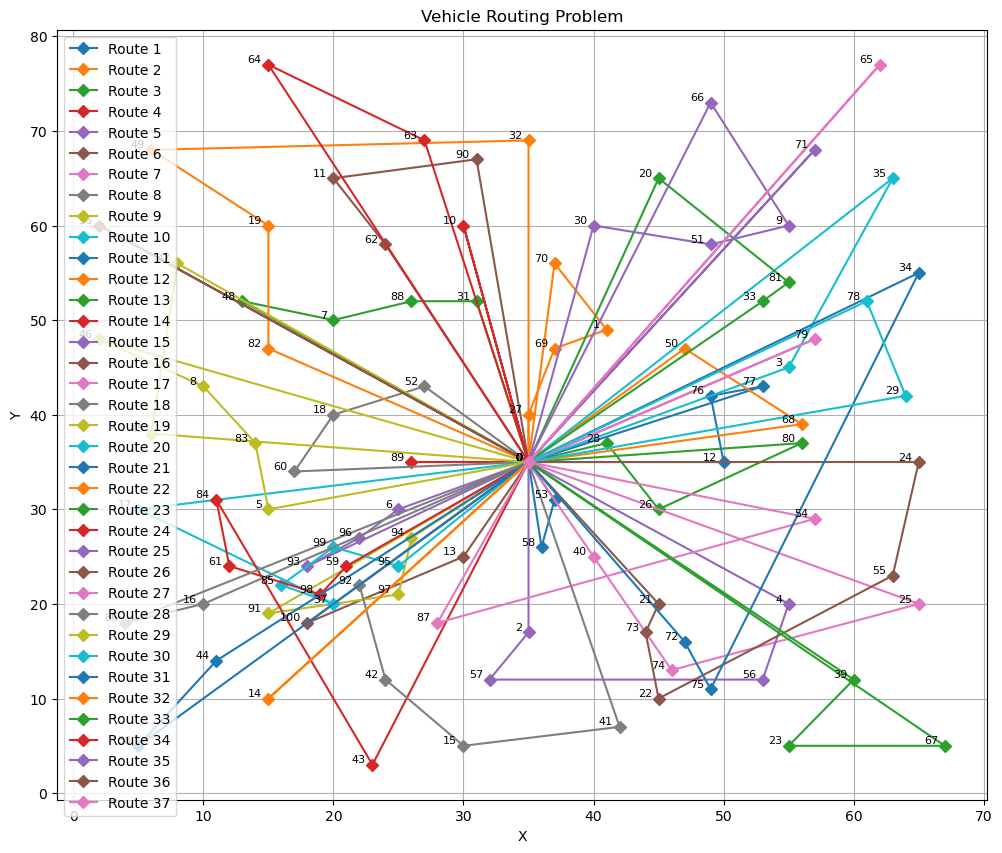

In [130]:
# Use two opt
def two_opt(routes, adj_matrix, num_iterations):
    """
    Enhanced Two-Opt heuristic for route optimization with time constraints.
    """
    best_routes = routes.copy()
    best_cost = sum(calculate_total_distance(route, adj_matrix) for route in best_routes)

    for _ in range(num_iterations):
        # Select a random route
        selected_route_index = np.random.randint(0, len(routes))
        selected_route = routes[selected_route_index]

        # Randomly pick two indices
        i, j = np.random.randint(1, len(selected_route) - 1, size=2)
        if j < i:
            i, j = j, i

        # Create a new route by reversing segment i to j
        new_route = selected_route.copy()
        new_route[i:j] = selected_route[j - 1:i - 1:-1]

        # Validate the route with time windows
        new_routes = routes.copy()
        new_routes[selected_route_index] = new_route

            # Calculate the cost for the new solution
        new_cost = sum(calculate_total_distance(route, adj_matrix) for route in new_routes)
        if new_cost < best_cost:
            best_routes = new_routes
            best_cost = new_cost

    return best_routes

def simulated_annealing(routes, adj_matrix, num_iterations, temperature):
    best_routes = routes.copy()
    current_routes = routes.copy()
    best_cost = sum(calculate_total_distance(route, adj_matrix) for route in best_routes)

    for _ in range(num_iterations):
        temp = max(0.01, temperature * (1 - (_ / num_iterations)))  # Cool down

        # Random perturbation
        selected_route_index = np.random.randint(0, len(current_routes))
        i, j = np.random.randint(1, len(current_routes[selected_route_index]) - 1, size=2)
        if j < i: i, j = j, i
        perturbed_route = current_routes[selected_route_index].copy()
        perturbed_route[i:j] = current_routes[selected_route_index][j - 1:i - 1:-1]

        # Cost calculation
        perturbed_routes = current_routes.copy()
        perturbed_routes[selected_route_index] = perturbed_route
        perturbed_cost = sum(calculate_total_distance(route, adj_matrix) for route in perturbed_routes)

        # Accept or reject
        if (perturbed_cost < best_cost or
            np.random.rand() < np.exp((best_cost - perturbed_cost) / temp)):
            current_routes = perturbed_routes
            if perturbed_cost < best_cost:
                best_routes = perturbed_routes
                best_cost = perturbed_cost

    return best_routes



def vrp_solver2(location, num_iterations):
    """
    Solve the VRP using the provided location for coordinates, vehicle capacity,
    and number of iterations for the two-opt optimization.
    """
    nb_vehicle, capacity_max, coordinates, demand, earliest_time, latest_time, service_time = read_txt_file(location)
    adj_matrix = adjacency_matrix(coordinates)
    all_routes, capacity_list, route_times, start_list = nearest_neighbor_with_time_windows(adj_matrix, demand, int(capacity_max), earliest_time, latest_time, service_time)
    #optimized_routes = two_opt(all_routes, adj_matrix, num_iterations)
    optimized_routes = simulated_annealing(all_routes, adj_matrix, num_iterations, 2000)
    route_distances = [calculate_total_distance(route, adj_matrix) for route in optimized_routes]
    formatted_routes = format_output(optimized_routes)
    return formatted_routes, route_distances, capacity_list, route_times, coordinates, start_list

# Main execution
num_iterations = 100000
solution, route_distances, capacity_list, route_times, coordinates, start_list = vrp_solver2(location, num_iterations)

# Display results
n = 0
for route, distance, route_time, start in zip(solution, route_distances, route_times, start_list):
    end = convert_time(start + route_time)
    print(f"Route {n+1}: {route}\nTruck capacity: {capacity_list[n]}\n"
          f"Total distance travelled: {distance}\n"
          f"Starting time: {convert_time(start)}\n"
          f"Ending time: {end}\n"          
          f"Total time: {convert_time(route_time)}\n"
          )
    n += 1

# Plot routes
plot_routes_with_coordinates(coordinates, solution)


### Tabu list


--- Initial Solution ---
Routes: [[0, 20, 21, 47, 0], [0, 22, 49, 0], [0, 67, 65, 63, 62, 66, 69, 75, 0], [0, 23, 52, 0], [0, 24, 25, 27, 28, 26, 34, 50, 0], [0, 5, 3, 4, 1, 0], [0, 7, 8, 9, 6, 2, 0], [0, 43, 42, 41, 40, 44, 45, 48, 51, 91, 0], [0, 10, 11, 12, 99, 0], [0, 74, 72, 61, 64, 68, 0], [0, 29, 30, 36, 0], [0, 46, 59, 80, 0], [0, 90, 89, 0], [0, 87, 86, 84, 85, 88, 0], [0, 13, 17, 18, 19, 15, 16, 14, 100, 0], [0, 98, 96, 95, 94, 93, 97, 79, 0], [0, 32, 33, 31, 35, 37, 38, 39, 0], [0, 83, 82, 77, 0], [0, 57, 55, 54, 53, 56, 58, 60, 0], [0, 92, 73, 0], [0, 81, 78, 76, 71, 70, 0]]
Cost: 1871


--- Optimized Solution ---
Routes: [[0, 21, 20, 47, 0], [0, 22, 49, 0], [0, 75, 65, 63, 62, 66, 69, 67, 0], [0, 23, 52, 0], [0, 24, 25, 26, 28, 27, 34, 50, 0], [0, 5, 3, 4, 1, 0], [0, 7, 8, 9, 6, 2, 0], [0, 91, 41, 40, 42, 44, 45, 48, 51, 43, 0], [0, 10, 11, 12, 99, 0], [0, 74, 72, 61, 64, 68, 0], [0, 29, 36, 30, 0], [0, 46, 59, 80, 0], [0, 90, 89, 0], [0, 87, 86, 84, 85, 88, 0], [0, 13, 1

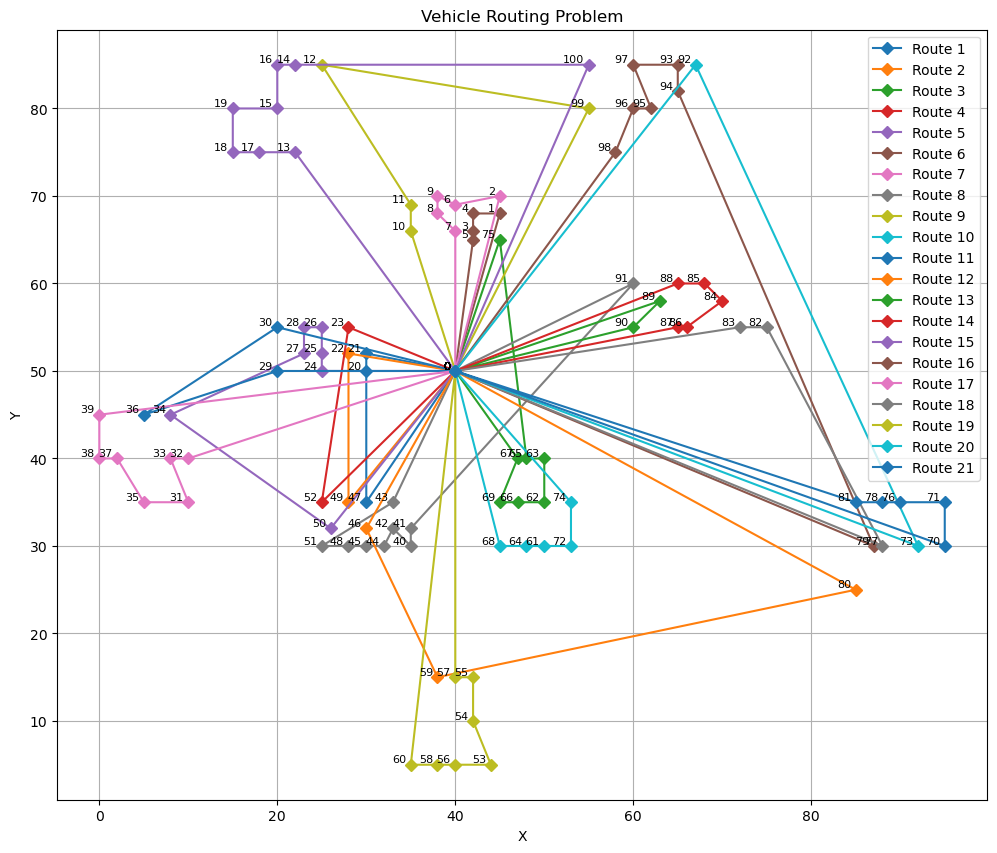

In [145]:
def tabu_search(initial_solution, adj_matrix, demands, capacity_max, num_iterations=100, tabu_tenure=10):
    """
    Tabu Search to optimize VRP solutions.
    """
    best_solution = initial_solution
    best_cost = sum(calculate_total_distance(route, adj_matrix) for route in best_solution)
    current_solution = initial_solution
    current_cost = best_cost

    tabu_list = []
    tabu_tenure_dict = {}

    for iteration in range(num_iterations):
        neighbors = generate_neighbors(current_solution, adj_matrix, demands, capacity_max)
        neighbors = sorted(neighbors, key=lambda x: x[1])  # Sort neighbors by cost

        selected_neighbor = None

        for neighbor, cost in neighbors:
            if neighbor not in tabu_list or cost < best_cost:
                selected_neighbor = (neighbor, cost)
                break

        if selected_neighbor:
            current_solution, current_cost = selected_neighbor
            tabu_list.append(current_solution)
            if len(tabu_list) > tabu_tenure:
                tabu_list.pop(0)

            if current_cost < best_cost:
                best_solution = current_solution
                best_cost = current_cost

    return best_solution, best_cost

def tabu_vrp_solver(location):
    """
    Solve the VRP using Tabu Search.
    """
    nb_vehicle, capacity_max, coordinates, demand, earliest_time, latest_time, service_time = read_txt_file(location)
    adj_matrix = adjacency_matrix(coordinates)

    # Step 1: Generate initial solution
    initial_routes, capacity_list, initial_times, start_list = nearest_neighbor_with_time_windows(
        adj_matrix, demand, int(capacity_max), earliest_time, latest_time, service_time
    )
    initial_routes = format_output(initial_routes)
    initial_cost = sum(calculate_total_distance(route, adj_matrix) for route in initial_routes)
    
    # Print initial solution
    print("\n--- Initial Solution ---")
    print(f"Routes: {initial_routes}\nCost: {ceil(initial_cost)}\n")

    # Step 2: Tabu Search Optimization
    optimized_routes, optimized_cost = tabu_search(initial_routes, adj_matrix, demand, int(capacity_max))

    # Format and return results
    optimized_capacity_list = [
        sum(demand[node] for node in route if node != 0) for route in optimized_routes
    ]
    route_times = [
        calculate_total_distance(route, adj_matrix) for route in optimized_routes
    ]

    return initial_routes, initial_cost, optimized_routes, optimized_cost, optimized_capacity_list, route_times, coordinates, start_list

# Résolution avec Tabu Search
initial_routes, initial_cost, optimized_routes, optimized_cost, optimized_capacity_list, optimized_route_times, coordinates, start_list = tabu_vrp_solver(location)

# Affichage final de la solution optimisée
print("\n--- Optimized Solution ---")
print(f"Routes: {optimized_routes}\nCost: {ceil(optimized_cost)}\n")

n = 0
for route, distance, route_time, start, capacity in zip(
    optimized_routes, optimized_route_times, optimized_route_times, start_list, optimized_capacity_list
):
    end = convert_time(start + route_time)
    print(f"Route {n+1}: {route}\nTruck capacity: {capacity}\n"
          f"Total distance travelled: {distance}\n"
          f"Starting time: {convert_time(start)}\n"
          f"Ending time: {end}\n"
          f"Total time: {convert_time(route_time)}\n")
    n += 1

# Visualisation des routes optimisées
plot_routes_with_coordinates(coordinates, optimized_routes)


In [ ]:
def nearest_neighbor_with_multiple_tours(adj_matrix, demands, capacity_max, earliest_time, latest_time, service_time, max_work_time):
    """
    Nearest Neighbor heuristic with multiple tours for a single vehicle in one day.
    """
    num_points = adj_matrix.shape[0]  # Total number of points (customers + depot)
    visited = [False] * num_points    # Array to check if a point has been visited
    routes = []                       # List to store routes
    capacities = []                   # List to store the capacities of vehicles for each route
    route_times = []                  # List to store the travel times for each route
    start_times = []                  # List to store the start times for each route

    while sum(visited) < num_points:  # While there are still points to visit
        current_node = 0              # Start from the depot
        current_capacity = 0          # Initial truck capacity
        current_time = earliest_time[current_node]  # Initial time (usually 0)
        route = [current_node]         # List for the current route, starting from the depot
        visited[current_node] = True    # Mark the depot as visited

        total_work_time = 0  # Accumulated total work time for this truck
        
        while True:
            last_node = route[-1]      # Last visited point of the route
            nearest = None             # The nearest neighbor to determine
            min_distance = float('inf')  # Initialize with a very large distance

            # Searching for the nearest neighbor
            for neighbor in [i for i, v in enumerate(visited) if not v]:
                travel_time = adj_matrix[last_node, neighbor]  # Travel time to the neighbor
                arrival_time = current_time + travel_time      # Arrival time at the neighbor

                # Check the constraints: capacity and time window
                if (demands[neighbor] + current_capacity <= capacity_max
                        and arrival_time <= latest_time[neighbor]  # Does not exceed the latest time
                        and total_work_time + travel_time <= max_work_time  # Does not exceed max work time
                        and adj_matrix[last_node, neighbor] < min_distance):  # If the distance is shorter
                    nearest = neighbor  # The nearest neighbor
                    min_distance = adj_matrix[last_node, neighbor]  # Update the minimum distance

            # If no neighbor is found, end the current route
            if nearest is None:
                break

            # Update the route, time, and capacity
            travel_time = adj_matrix[last_node, nearest]
            current_time += travel_time
            total_work_time += travel_time
            current_time = max(current_time, earliest_time[nearest])  # Wait if arriving too early
            current_time += service_time[nearest]  # Add service time for the customer
            total_work_time += service_time[nearest]  # Add service time to the total work time

            route.append(nearest)  # Add the point to the route
            visited[nearest] = True  # Mark the point as visited
            current_capacity += demands[nearest]  # Increase the capacity

            # Check if total work time exceeds the limit
            if total_work_time > max_work_time:
                break

        # Return to the depot
        travel_time = adj_matrix[route[-1], 0]  # Travel time to return to the depot
        current_time += travel_time
        total_work_time += travel_time
        route.append(0)  # Add the depot at the end of the route

        routes.append(route)  # Add the full route to the list
        capacities.append(current_capacity)  # Add the used capacity
        route_times.append(current_time)  # Add the total time of the route
        start_times.append(max(0, earliest_time[route[1]] - adj_matrix[route[0], route[1]]))

    return routes, capacities, route_times, start_times

## to se tomorrow